In [12]:
import wget
import os
if not os.path.exists("colour_mnist.py"):
    wget.download("https://raw.githubusercontent.com/clovaai/rebias/master/datasets/colour_mnist.py", "colour_mnist.py")

if not os.path.exists("flac.py"):
    wget.download("https://raw.githubusercontent.com/gsarridis/FLAC/main/flac.py", "flac.py")

In [13]:
from colour_mnist import get_biased_mnist_dataloader
trainloader = get_biased_mnist_dataloader(root='./data', batch_size=128, data_label_correlation=0.99, train=True)
testloader = get_biased_mnist_dataloader(root='./data', batch_size=128, data_label_correlation=0.1, train=False)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        # https://github.com/gsarridis/FLAC/blob/main/models/simple_conv.py
        super().__init__()
        dims = 6
        self.conv1 = nn.Conv2d(3, dims, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(dims, 16, 5)
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.normalize(x, dim=1)
        features = x
        x = self.fc(x)
        return x, features

In [23]:
import fairbench as fb
import tqdm

fb.setbackend("torch")

def evaluate(net):
    n_classes = 10
    n_sensitive = 10
    class_evals = dict()
    with torch.no_grad():
        for data in tqdm.tqdm(testloader):
            images, labels, sensitive = data
            outputs, _ = net(images)
            _, predicted = torch.max(outputs.data, 1)
            for cl in range(n_classes):
                ret = fb.todict(predictions=(predicted==cl), 
                              labels=(labels==cl), 
                              sensitive=fb.Fork({f"sensitive{i}": sensitive==i for i in range(n_sensitive)}))
                class_name = f"class{cl}"
                class_evals[class_name] = fb.concatenate(class_evals.get(class_name, None), ret)
    return class_evals

In [21]:
net = Net()
net.load_state_dict(torch.load('./data/model.pth'))
net.eval()
kwargs = evaluate(net)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.03it/s]


In [22]:
fair_net = Net()
fair_net.load_state_dict(torch.load('./data/fair_model.pth'))
fair_net.eval()
fair_kwargs = evaluate(fair_net)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.83it/s]


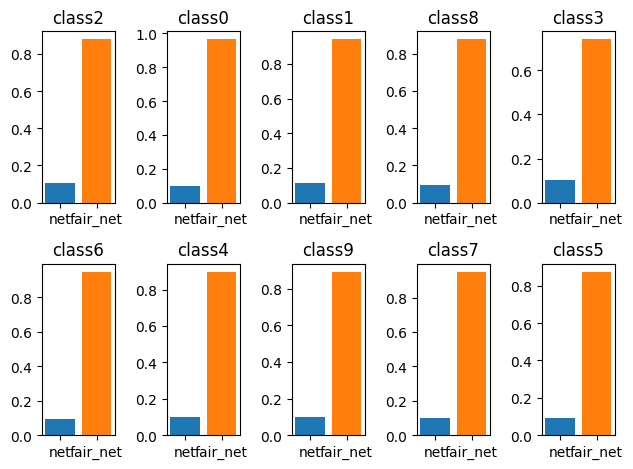

In [10]:
#accuracy = fb.reduce(fb.report(fb.Fork(kwargs), metrics=[fb.accuracy]).accuracy, fb.min, name=None)
accuracy = fb.areduce(fb.areport(fb.Fork(kwargs), metrics=fb.accuracy), fb.min)
fair_accuracy = fb.multireport(fb.Fork(fair_kwargs)).min.accuracy
comparison = fb.Fork(net=accuracy, fair_net=fair_accuracy)
fb.visualize(comparison)

In [8]:
comparison.class3.explain

net,"sensitive0: tensor(0.8994, dtype=torch.float64) sensitive9: tensor(0.8987, dtype=torch.float64) sensitive7: tensor(0.8993, dtype=torch.float64) sensitive6: tensor(0.8986, dtype=torch.float64) sensitive2: tensor(0.8985, dtype=torch.float64) sensitive5: tensor(0.8986, dtype=torch.float64) sensitive1: tensor(0.8993, dtype=torch.float64) sensitive4: tensor(0.8989, dtype=torch.float64) sensitive3: tensor(0.1006, dtype=torch.float64) sensitive8: tensor(0.8993, dtype=torch.float64)"
fair_net,"sensitive0: tensor(0.9711, dtype=torch.float64) sensitive9: tensor(0.9739, dtype=torch.float64) sensitive7: tensor(0.9741, dtype=torch.float64) sensitive6: tensor(0.9508, dtype=torch.float64) sensitive2: tensor(0.9055, dtype=torch.float64) sensitive5: tensor(0.9187, dtype=torch.float64) sensitive1: tensor(0.9681, dtype=torch.float64) sensitive4: tensor(0.9600, dtype=torch.float64) sensitive3: tensor(0.7400, dtype=torch.float64) sensitive8: tensor(0.9382, dtype=torch.float64)"


In [11]:
comparison.class3.explain.net

sensitive0,0.899402390438247
sensitive9,0.8986960882647944
sensitive7,0.8993020937188435
sensitive6,0.8985943775100401
sensitive2,0.8984924623115578
sensitive5,0.8985943775100401
sensitive1,0.8993020937188435
sensitive4,0.8988988988988988
sensitive3,0.10059760956175301
sensitive8,0.8993020937188435
